# "Bayesian Parameter Estimation"
> "We illustrate a simple Bayesian Parameter Estimation workflow by following Chapters 2 and 3 of Sivia and Skilling's book."

- toc:true
- branch: master
- badges: true
- comments: true
- author: John J. Molina
- categories: [Data Analysis, Parameter Estimation]

# Motivation / Disclaimer

This is the first in what I hope will be a long series of posts on Data Analysis, Probabilistic Programming and Machine Learning.
We have recently become interested in incorporating such techniques into our more traditional Physics simulations and for this, we started a Seminar/Reading club with colleages in our University.
I plan to posts all of our study guides here. These posts are only intended as an easy way to store and retrieve our notes, nothing more...so expect brevity and don't be too dissapointed if you find any glaring mistakes and/or omisions (but please let me know if you do).

We start with the basics of Bayesian Data Analysis, following the excellent tutorial book "Data Analysis : A Bayesian Tutorial", written by Dr. Devinder S. Sivia, with contributions by Prof. John Skilling.
Dr. Sivia is a research scientist at the Rutherford Appleton Lab and Prof. Skilling was at the DAMPT (Cambridge) before becoming a founding director of the Maximum Entropy Data Consultants group. The book is written by/for physicist and includes advanced topics (such as Maximum Entropy and Nested Sampling) that we hope to cover in future posts. 

# References
While mainly following Sivia's book, we have also found the following references extremely helpful

- Data Analysis : A Bayesian Tutorial, second edition. D.S. Sivia with J. Skilling, Oxford, Oxford University Press (2006)
- Probability Theory: The Logic of Science. E. T. Jaynes, Cambridge, Cambridge Unviversity Press (2003)
- [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), Thrid Edition. A. Gelman, J. B. Carlin, H. Stern et al., Chapman & Hall/CRC Texts in Statistical Science (2013)
- "Frequentism and Bayesianism" Blog-Post series ([I](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/), [II](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/), [III](jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/), [IV](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/), [IV](http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/)) by Jake VanderPlas
- Michael Betancourt's [writings](https://betanalpha.github.io/writing/) on probability theory.

# Preliminaries

## Basic Rules
The probability $P(X\lvert I)$ expresses our belief that $X$ is true given prior information $I$. The two basic rules of probability theory are just the sum and product rules,
$$\begin{align}
P(X\lvert I) + P(\overline{X}\lvert I) &= 1 &\textrm{(Sum Rule)}\label{e:sum_rule}\\
P(X,Y\lvert I) &= P(X\lvert Y, I)\times P(Y\lvert I) &\textrm{(Product Rule)}\notag\\
&=P(Y\lvert X, I)\times P(X\lvert I) \label{e:product_rule} \\
\end{align}$$
where $\overline{X}$ denotes the negation of $X$.
See Sivia or Jaynes for a derivation, originally due to Cox, which shows that these are the only rules that will guarantee consistency.

From the product rule, one can easily derive Bayes' Theorem
$$\begin{align*}
\overbrace{P(X \lvert Y, I)}^{\small{\mathrm{posterior}}} &= \frac{\overbrace{P(Y\lvert X,I)}^{\small{\mathrm{likelihood}}} 
                                          \times\overbrace{P(X\lvert I)}^{\small{\mathrm{prior}}}}{\underbrace{P(Y\lvert I)}_{\small{\mathrm{evidence}}}}&\textrm{(Bayes' Theorem)}\label{e:bayes}
\end{align*}$$
which states that the "posterior" is proportional to the "likelihood" times the "prior", with the "evidence" a normalization constant. Posterior, likelihood and prior are the standard terms for these quantities, but the "evidence" label seems not to be widespread (we are following Sivia's nomenclature here). Note that there is nothing special about these labels, one's prior can be another's posterior, and your posterior today can be your prior tomorrow. Basically, the posterior is what we want to calculate, but can't (at least not directly), the prior is what we start with, and the likelihood is something we can easily calculate.

The sum rule can be extended to the to a series of mutually esclusive and exhaustive set of propositions $\{Y_k\}$, such that $\sum_k P(Y_k\lvert I) = 1$, and in the continuum limit we obtain the following marginalization property

$$\begin{align*}
P(X\lvert I) &= \int\textrm{d}Y P(X, Y\lvert I) =\int\textrm{d}Y P(X\lvert Y, I)\times P(Y\lvert I) &\textrm{(Marginalization)}
\label{e:marginalization}
\end{align*}$$

This is incredibly usefull when there are unknown quantities that are required to compute the likelihood, but which are not really of interest to us. These so-called nuissance parameters can then be introduced and integrated out. We are being a bit careless here, and intermixing probabilities with probability densities. Strictly speaking, if $Y$ is a real random variable we should say that the probability for $Y$ to be within the range $y-\Delta y \le Y \le y+\Delta y$ is

$$\begin{align*}
P(y - \Delta y \le Y \le y + \Delta y)= \rho(Y=y)\Delta t
\end{align*}$$

with $\rho$ the probability density function. However, following Sivia we will use the same symbol for both quantities, as it should be apparent from the context which one we are referring to.

## Bayesian Data Analysis
It is easier to recognize how this Bayesian framework fits within a Data Analysis problem if we rewrite Bayes theorem in the form

$$\begin{align*}
P(\textrm{Hypothesis}\lvert \textrm{Data}, I) &= \frac{P(\textrm{Data}\lvert \textrm{Hypothesis}, I)\times P(\textrm{Hypothesis}\lvert I)}{P(\textrm{Data}, I)}\label{e:bayes_hypothesis}
\end{align*}$$

or as

$$\begin{align*}
P(\Theta\lvert D, I) &= \frac{P(D\lvert\Theta, I) \times P(\Theta\lvert I)}{P(D\lvert I)} \label{e:bayes_theta}\\
&\propto P(D\lvert\Theta, I)\times P(\Theta\lvert I)
\end{align*}$$

where $\Theta$ denotes the parameters of our model, $D$ our measured experimental/simulation data. The questions we are looking to answer, which these posteriors allow us to formulate are the following: "What does my data say about my hypothesis" or "What does my data say about the model parameters"? For what follows, we will focus exclusively on the parameter estimation problem.

## One shot or sequential analysis? 

Assume that our experimental data consists of a series of $N$ measurements, $D = \{D_k\}_{k=1}^N$. Our prior information $I$ specifies the model we believe explains this data, and we want to infer the parameters of this model.

Thus, what we want is the posterior of $\Theta$ given $D$, which gives
$$\begin{align*}
P(\Theta\lvert D,I) &\propto P(\{D_k\}_{k=1}^N\lvert \Theta, I)\times P(\Theta\lvert I) \\
&= P(\{D_k\}_{k=2}^N\lvert D_1, \Theta, I) \times P(D_1\lvert \Theta, I)\times P(\Theta\lvert I) \\
&= P(\{D_k\}_{k=2}^N\lvert \Theta, I)\times P(D_1\lvert \Theta, I)\times P(\Theta\lvert I) \\ 
&= P(\{D_k\}_{k=3}^N\lvert \Theta, I)\times P(D_2\lvert \Theta, I)\times P(D_1\lvert \Theta, I) \times P(\Theta\lvert I) \\
&\vdots \\
&= \left(\Pi_{k=1}^N P(D_k\lvert \Theta, I)\right) \times P(\Theta\lvert I)
\end{align*}$$

In step $2$, we are using the product rule to peel off one of the $D_i$, then in step $3$, we assume that (given the prior and the model parameters), knowledge of $D_1$ does not give us any extra information regarding the probabilities of observing $\{D_k\}_{k\ge 2}$, which means that they are independent. This procedure can be repeated until the original (one-shot) likelihood, which quantifies the probability of obtaining the entire set of data, is written as a product of individual likelihoods. From this, it is easy to see that we can analyze the data in one-shot, or sequentially, as the measurements arrive. The two routes are equivalent.

To see this, consider the expression obtained after peeling off m elements from the original likelihood. The posterior is given as
$$\begin{align*}
P(\Theta\lvert D,I)&\propto \big(\Pi_{k=m+1}^{N} P(D_k\lvert \Theta, I)\big) \big(\Pi_{j=1}^{m} P(D_j\lvert\Theta, I)\big) P(\Theta\lvert I) \\
&\propto\big(\Pi_{k=m+1}^{N} P(D_k\lvert \Theta, I)\big) \times P(\Theta\lvert \{D_j\}_{j=1}^m, I)
\end{align*}$$
where the second and third terms in the rhs of the first equation are nothing but the likelihood and the prior after obtaining the first $m$ measurements.
Thus, we can analyze the first $m$ data points, obtaining a posterior $P(\Theta\lvert \{D_j\}_{j=1}^m, I)$, and then use this as a prior when analyzing the remaining $N-m$ points.

What we can never ever do, however, is to use the posterior $P(\Theta\lvert \{D_j\}_{j=1}^m, I)$ to re-analyze the $\{D_j\}_{j=1}^m$ measurements! 

# Laplace's Approximation, Best Estimates and Error Bars

Everything we can say about our parameters, given the Data and prior information, is contained in the posterior $P(\Theta\lvert D, I)$. However, this quantity can be quite complicated to deal with, particularly when the number of parameters exceeds 3. Therefore, it can be usefull to develop approximations to this posterior. In particular, if the distribution is simple enough we can try to approximate it with a Gaussian distribution. Then, all that are needed are the first two moments, i.e., the average and the variance. The average give the peak of the distribution (the most likely point) and the variance an estimate of its spread, and thus of the reliability of our estimate.

This approximation is commonly referred to as Laplace's approximation, and amounts to a Taylor expansion of the logarithm of the posterior around the maximum (truncated to second order). Consider the general multi-dimensional case with $p$ parameters, $\Theta = (\Theta^{1}, \Theta^{2}, \ldots, \Theta^{p})$, and let $\Theta_0 = \text{argmax}{P(\Theta\lvert D, I)}$

$$\begin{align*}
L &= \ln{P(\Theta\lvert D, I)} = \ln P \\
&= L\lvert_{\Theta_0} + \nabla L\lvert_{\Theta_0}\cdot(\Theta - \Theta_0) 
+ \frac{1}{2} (\Theta-\Theta_0)^{t}\cdot\nabla\nabla L\lvert_{\Theta_0}\cdot(\Theta-\Theta_0) + \mathcal{O}\big((\Theta-\Theta_0)^3\big) \\
&\simeq L\lvert_{\Theta_0} + \frac{1}{2} (\Theta-\Theta_0)^{t}\cdot\nabla\nabla L\lvert_{\Theta_0}\cdot(\Theta-\Theta_0)
\end{align*}$$

where $\nabla=\nabla_{\Theta}$, $A^t$ denotes the transpose of $A$, $(\cdot)$ a matrix-matrix multiplication, and $\nabla\nabla L$ is the (hessian) matrix of second derivatives. Notice that the first-order term vanishes, since $\nabla L\lvert_{\Theta_0} = 0$ by definition.

We can then re-exponentiate this expression to obtain an approximation to our original posterior distribution
$$\begin{align*}
P(\Theta\lvert D,I)\propto \exp{\left[-\frac{1}{2} \left(\Theta-\Theta_0\right)^t \cdot 
\left(-\nabla\nabla L\lvert_{\Theta_0}\right)\cdot\left(\Theta-\Theta_0\right)\right]}
\end{align*}$$

## Multi-variate Gaussians
Recall the definition of a [multi-variate Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) for a random $d$-dimensional vector $A$, expressed as $A\sim \mathcal{N}(\mu, \Sigma)$
$$\begin{align*}
\mathcal{N}(A \lvert \mu, \Sigma) &=
\frac{1}{\sqrt{(2\pi)^d \det{\Sigma}}} \exp{\left[-\frac{1}{2}\left(A-\mu\right)^t \cdot \Sigma^{-1}\cdot\left(A-\mu\right)\right]} \\
\left\langle A \right\rangle &= \mu \\
\left\langle(A^i - \mu^i)(A^j - \mu^j)\right\rangle &= \Sigma^{ij} \\
\int\text{d}A \mathcal{N}(A\lvert \mu, \Sigma) &=1
\end{align*}$$
where $\langle\cdot\rangle$ denotes an average over $P_{\mathcal{N}}$.

Such distributions have many interesting properties. In particular, if A is partitioned into $B$ and $C$, $A=\begin{pmatrix}B\\C\end{pmatrix}$, the marginalization over $B$ ($C$), results in another multi-variate Gaussian distribution for $C$ ($B$)
$$\begin{align*}
P(B\lvert \mu, \Sigma) &=\int\textrm{d}C \mathcal{N}\left(\left.\begin{pmatrix}B\\C\end{pmatrix}\right\lvert \begin{pmatrix}\mu_B\\\mu_C\end{pmatrix}, \begin{pmatrix}\Sigma_{BB} &\Sigma_{BC}\\\Sigma_{CB}&\Sigma_{CC}\end{pmatrix}\right)\\
&= \frac{1}{\sqrt{(2\pi)^{d_B} \det{\Sigma_{BB}}}} \exp{\left[-\frac{1}{2}\left(B - \mu_B\right)^t \Sigma_{BB}^{-1}\left(B - \mu_B\right)\right]}\\
&\equiv \mathcal{N}(\mu_{B}, \Sigma_{BB})
\end{align*}$$
This can be easily proved by completing the squares in the exponent of the joint distribution.

Thus, since each component of $A$ is itself described by a Gaussian distribution, the best estimate is given by
$$\begin{align*}
A &= \mu\pm \sigma\\
\sigma &= \sqrt{\text{diag}{\Sigma}}
\end{align*}$$

Finally, we see that the Laplace approximation of the posterior distribution for $\Theta$ is nothing but a multi-variate Gaussian, with average and covariance matrix given by
$$\begin{align*}
\mu&\rightarrow \Theta_0 \\
\Sigma&\rightarrow (-\nabla\nabla L\lvert_{\Theta_0})^{-1}
\end{align*}$$

# Bayesian Parameter Estimation

## Fitting with (known) noise

Let's see how this Bayesian formalism can be applied in practice.
Our data consists of a series of noisy measurements $D= \{y_k\}_{k=1}^N$, which on prior information $I$ are assumed to be generated by a model $y = f(X; \Theta)$, parametrized by $p$ parameters $\Theta = (\Theta^1, \ldots, \Theta^p)$. We consider the case where $X=(X^1, \ldots, X^d)$ is a d-dimensional vector, but $y$ is assumed to be a scalar.

The posterior for $\Theta$, given the Data $D$ and the prior information $I$, is then
$$\begin{align*}
P(\Theta\lvert D, I) &\propto P(D\lvert \Theta, I)\times P(\Theta\lvert I) \\
&\propto \Pi_k P(y_k\lvert \Theta, I) \\
&=\Pi_k \frac{1}{\sqrt{2\pi} \sigma_k} \exp{\left[-\frac{\big(y_k - f(X_k; \Theta)\big)^2}{2\sigma_k^2}\right]} \\
\end{align*}$$
where we have assumed that :
- The prior $P(\Theta\lvert I)$ is a constant
- The $y_k$ are independent of each-other (on knowing $\Theta$ and $I$), such that $P(y_i,y_j\lvert \Theta, I) = P(y_i\lvert \Theta, I) P(y_j\lvert \Theta, I)$ for $i\ne j$.
- The measurement error, and thus the likelihood, is Gaussian with variance $\sigma_k^2$

Let's see what the best-esimate would be in this case.

In practice, it will be more convenient to work with the logarithm of the probabilities, than with the probabilities themseleves. Since $\ln$ is a monotonically increasing function, the maximum of $P$ will coincide with the maximum of $\ln{P}$. The log posterior is given by

$$\begin{align*}
L &= \textrm{constant} -\sum_k \frac{\left(y_k - f(X_k; \Theta)\right)^2}{2\sigma_k^2} \\
&= \textrm{constant} - \frac{1}{2}\chi^2
\end{align*}$$
where $\chi^2=\sum_k(y_k - f_k)^2/\sigma_k^2$ is the sum of the squared residuals, weighted by the inverse of the error, and all terms not depending on $\Theta$ have been absorbed into the normalization constant. 

The best estimate $\Theta_0$, which maximizes the posterior, is found by setting the gradient of $L$ to zero,

$$\begin{align*}
\nabla L = -\frac{1}{2}\nabla \chi^2 = 0 \Longrightarrow \nabla\chi^2 = 0
\end{align*}$$

which coincides with setting the gradient of $\chi^2$ to zero. Thus, in this case, maximizing the posterior is equivalent to a least-squares fit!

Finally, our reliability estimate is obtained by computing the matrix of second derivatives, evaluated at the optimal value $\Theta_0$
$$\begin{align*}
\Sigma_{\Theta}^{-1}=- \nabla\nabla L\lvert_{\Theta_0} = \frac{1}{2}\nabla\nabla\chi^2\lvert_{\Theta_0}
\end{align*}$$


Approximating our posterior as a Gaussian, our best estimate for the model parameters would be
$$\begin{align*}
\Theta = \Theta_0 \pm \sigma_{\Theta}\; \qquad \left(\sigma_{\Theta}= \sqrt{\text{diag}(\Sigma_{\Theta})}\right)
\end{align*}$$

## Fitting with uknown noise

What happens in the case where don't have an estimate of the error bars? How would we derive the best-estimate in this case? What quantity should we minimize?

The solution is simply, use marginalization and average over all possible values of $\sigma$ (assumed to be the same for all points)
$$\begin{align}
P(\Theta\lvert D, I) &=\int\textrm{d}\sigma\, P(\Theta, \sigma\lvert D, I)\\
&\propto \int\textrm{d}\sigma\, P(D\lvert \Theta, \sigma, I) \times P(\Theta, \sigma\lvert I)
\end{align}$$
where the last step uses Bayes' to write the integrand as the likelihood and the prior. Notice that this is the average of $P(D\lvert \Theta, \sigma, I)$ over $P(\Theta,\sigma\lvert I)$.


Under the same simplifying assumptions as above, i.e., independent measurements, uniform prior for $\Theta$, and Gaussian noise, we can again decompose the likelihood of $D$ into a product of likelihoods for the individual measurements
$$\begin{align}
P(\Theta\lvert D, I) &\propto \int_0^\infty\textrm{d}\sigma \left(\Pi_k \frac{1}{\sqrt{2\pi}\sigma} \exp{\left[-\frac{\left(y_k - f(X_k; \Theta)\right)^2}{2\sigma^2}\right]}\right) \times \frac{1}{\sigma} \\
&= (2\pi)^{-N/2}\int_0^\infty\frac{\textrm{d}\sigma}{\sigma} \sigma^{-N}\exp{\left[-\frac{1}{2\sigma^2}\sum_k\left(y_k - f(X_k; \Theta)\right)^2\right]}
\end{align}$$

Here we have used [Jeffreys' prior](https://en.wikipedia.org/wiki/Jeffreys_prior) for $\sigma$, $P(\sigma\lvert I)\propto 1/\sigma$, as it is a scale-parameter. Depending on your prior information (e.g., do you know the order of magnitude?), there may be more appropriate priors, but we leave that for a future discussion. See Sivia and or Jaynes for a more in depth review of such issues. In practice, if $N$ is large enough this will not make a big difference, choosing Jeffreys prior or a constant prior for $\sigma$ will give essentially the same predictions.

The integral over $\sigma$ can be done analytically throught the following variable transformation, with $S = \sum_k (y_k - f_k)^2$
$$\begin{align}
t &= \frac{\sum_k \left(y_k - f(X_k; \Theta)\right)^2}{2 \sigma^2}  = \frac{S}{2\sigma^2}\\
\frac{\textrm{d}\sigma}{\sigma} &= -\frac{\textrm{d}t}{2t}
\end{align}$$

The posterior is then
$$\begin{align}
P(\Theta\lvert D, I) &\propto (2\pi)^{-N/2}\int_0^\infty \frac{\textrm{d}t}{2t} \left(\frac{2t}{S}\right)^{N/2} e^{-t} \\
&= \frac{\pi^{-N/2}}{2}\underbrace{\left(\int_0^\infty \frac{\textrm{d}t}{t} t^{N/2} e^{-t}\right)}_{= \Gamma(N/2)}S^{-N/2} 
\end{align}$$

where the quantity in parenthesis is independent of $\Theta$ and equal to the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function) of $N/2$.

As before, let's look at the log-posterior

$$\begin{align}
L &= \textrm{constant} - \frac{N}{2} \ln{S}
\end{align}$$

The best-estimate is again that which maximizes $L$
$$\begin{align}
\nabla L &= -\frac{N}{2} \frac{\nabla S}{S}= 0 \Longrightarrow \nabla S = 0
\end{align}$$
which in this case corresponds to minimizing $\ln{S}$ or just $S$. So far it seems that the procedure is the same, minimize the sum of the squared residuals (weighted by the magnitude of the error, if known). The differences come when we consider the reliability estimate.

The Hessian is now
$$\begin{align}
\nabla\nabla L &= -\frac{N}{2}\left[\frac{\nabla\nabla S}{S} - \frac{\left(\nabla S\right)\left(\nabla S\right)}{S^2}\right]
\end{align}$$

which reduces to the following when evaluated at the optimum point $\Theta_0$ (since $\nabla S \lvert_{\Theta_0}\equiv 0$)
$$\begin{align}
\nabla\nabla L\lvert_{\Theta_0} &= -\frac{N}{2} \frac{\nabla\nabla S\lvert_{\Theta_0}}{S_0} = -\frac{1}{2} \left.\nabla\nabla\left(\frac{S}{S_0/N}\right)\right\lvert_{\Theta_0}
\end{align}$$

Within the Laplace approximation, the covariance matrix for the posterior distribution of $\Theta$ is then given by
$$\begin{align}
\Sigma_\Theta^{-1} &= -\frac{1}{2}\left(\left.\nabla\nabla\left(\frac{S}{S_0/N}\right)\right\lvert_{\Theta_0}\right)
\end{align}$$

This expression is very similar to the one we obtained above, in the case where the measurement error $\sigma$ was known, $\Sigma_\theta^{-1}=-\frac{1}{2}\nabla\nabla\chi^2\lvert_{\Theta_0}$. Here, we have replaced $\sigma_k^2$ with an estimate derived from the data $S_0/N$

$$\begin{align}
\chi^2 = \sum_k\frac{\left(y_k - f(X_k;\Theta)\right)^2}{\sigma_k^2} &\longrightarrow \frac{S}{S_0/N} = \frac{N}{S_0}\sum_k\left(y_k - f(X_k;\Theta)\right)^2 \\
\sigma_k^2 &\longrightarrow \frac{S_0}{N} = \frac{1}{N}\sum_{k}\left(y_k - f(X_k;\Theta_0)\right)^2
\end{align}$$

However, $S_0/N$ is not necessarily the best estimate for the amplitude of the noise, as we will see below.

### ... about the noise
What does the data say about the noise, i.e., what is $P(\sigma\lvert D, I)$? 

To be able to compute this quantity, we again make use of marginalization, treating the model parameters as nuissance parameters and integrating over them.
$$\begin{align}
P(\sigma\lvert D, I) &= \int\textrm{d}\Theta P(\sigma, \Theta\lvert D, I) \\
&\propto \int\textrm{d}\Theta P(D\lvert \sigma, \Theta, I) P(\sigma, \Theta\lvert I)
\end{align}$$

Assuming $\sigma$ and $\Theta$ are independent, $P(\sigma, \Theta\lvert I)= P(\sigma\lvert I) P(\Theta\lvert I)$, and taking a uniform prior for $\Theta$ and Jeffreys prior for $\sigma$, we have
$$\begin{align}
P(\sigma\lvert D, I)\propto \sigma^{-(N+1)}\int\textrm{d}\Theta\exp{\left[-\frac{S(\Theta)}{2\sigma^2}\right]}
\end{align}$$
where $S$ is still the sum of squared residuals $S = \sum_k (y_k - f(X_k;\Theta))$. We get one factor of $1/\sigma$ from the normalization constant of the likelihood for each data measurement, and one from the prior.

Without having to assume anything regarding the form of the model function $f(X)$, we can proceed by again using the Laplace approximation, now expanding $S(\Theta)$ around the minimum $\Theta_0$ (which corresponds to the maximum of the posterior $P(\Theta\lvert D, I)$)
$$\begin{align}
S \simeq S_0 + \nabla S\lvert_{\Theta_0} \cdot \left(\Theta-\Theta_0\right) + \frac{1}{2}\left(\Theta - \Theta_0\right)^t\cdot\nabla\nabla S\lvert_{\Theta_0}\cdot\left(\Theta-\Theta_0\right)
\end{align}$$

The posterior $P(\sigma\lvert D, I)$ is then
$$\begin{align}
P(\sigma\lvert D, I)&\propto \sigma^{-(N+1)}\exp{\left[-\frac{S_0}{2\sigma^2}\right]}\int\textrm{d}\Theta \exp{\left[-\frac{1}{2}\left(\Theta-\Theta_0\right)^t\cdot
\frac{\nabla\nabla S\lvert_{\Theta_0}}{2\sigma^2}\cdot\left(\Theta-\Theta_0\right)\right]} \\
&\propto\sigma^{p-(N+1)}\exp{\left[-\frac{S_0}{2\sigma^2}\right]}
\end{align}$$
where the $p$-dimensional integral over $\Theta$ gives us a factor of $\sqrt{(2\pi)^p\det{\Sigma}_{\sigma}}$, with $\Sigma_\sigma^{-1} = -\frac{1}{2\sigma^2} \nabla\nabla S\lvert_{\Theta_0}$.

To find the best-estimate for $\sigma$ we maximize the log posterior
$$\begin{align}
L &= \ln{P(\sigma\lvert D, I)} = \textrm{const} + \left(p - N - 1\right)\ln{\sigma} - \frac{S_0}{2\sigma^2} \\
\frac{\textrm{d}L}{\textrm{d}\sigma} &= (p-N-1)\frac{1}{\sigma} + \frac{S_0}{\sigma^3}\\
\frac{\textrm{d}^2L}{\textrm{d}^2\sigma} &= (N+1-p)\frac{1}{\sigma^2} - \frac{3 S_0}{\sigma^4}
\end{align}$$

Setting $\text{d} L / \text{d}\sigma\lvert_{\sigma_0} = 0$, we get
$$\begin{align}
\sigma_0^2 = \frac{S_0}{N+1-p}
\end{align}$$

with the reliability estimates given by the inverse of the Hessian
$$\begin{align}
\left.\frac{\textrm{d}^2L}{\textrm{d}^2\sigma}\right\lvert_{\sigma_0} &= \frac{(N+1-p)\sigma_0^2 - 3S_0}{\sigma_0^4}\\
&= \frac{-2(N+1-p)}{\sigma_0^2}
\end{align}$$

we get
$$\begin{align}
\sigma = \sigma_0 \pm \frac{\sigma_0}{\sqrt{2(N+1-p)}}
\end{align}$$

# Example : Fitting a Straigh-Line (with known measurement error)

Now, let's see how all this works out in practice. For convenience, we will use the [jax](https://github.com/google/jax) library and take advantage of its automatic differentiation capabilities, which allow us to calculate the gradients and Hessians exactly (to machine precision). If you are on Windows this will not work, in that case remove all the jax commands.

Within the Laplace approximation, we can work out the best estimates for all our quantities by simply maximizing the appropriate posterior. However, to compare with the full solution, we will also make use of the [PYMC3](https://docs.pymc.io/) library, which allows us to perform [Hamiltonian Monte-Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) simulations and generate samples which converge to those of the posterior. For the minimiztion, we make use of the [scipy](https://github.com/scipy/scipy/) library.

Please install the following packages  to run the code below
- numpy
- matplotlib
- pymc3
- theano
- scipy
- jax

In [73]:
#import numpy as np #### If using windows...
import jax.numpy as np
import numpy as onp
import numpy.random as random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from scipy.optimize import minimize
from jax import grad, jit, vmap, jacfwd, jacrev
from jax.config import config; config.update("jax_enable_x64", True)

In [77]:
mpl.style.use(['seaborn-poster', 'seaborn-muted'])

#betanalphas' colormap
color = {'light':"#DCBCBC",
         'light_highlight':"#C79999",
         'mid':"#B97C7C", 
         'mid_highlight':"#A25050", 
         'dark':"#8F2727", 
         'dark_highlight':"#7C0000", 
         'light_trans':"#DCBCBC20", 
         'dark_trans':"#8F272720", 
         'superfine':"#00000060"}

def hessian(f):
    """Returns a function which computes the Hessian of a function f
           if f(x) gives the values of the function at x, and J = hessian(f)
           J(x) gives the Hessian at x"""
    return jit(jacfwd(jacrev(f)))

def plot_quantiles(ax, xdata, ydata, colors=reds[2:], **kwargs):
    """Plot quantiles of data as a function of x
       Note : q-th quantile of 'data' is the value 'q' away from the minimum to the maximum in a sorted copy of 'data'"""
    quantiles = np.quantile(ydata,np.arange(0.1, 1.0, 0.1), axis=0) # [0.1, ..., 0.9] -> (80%, 60%, 40%, 20%) credible interval
    for i,c in zip(range(len(quantiles)//2), [colors[0], colors[1], colors[2], colors[3]]): 
        ax.fill_between(xdata, quantiles[i,:], quantiles[-(i+1),:], color=c) 
    ax.plot(xdata, quantiles[4], color=colors[4], lw=4, **kwargs)

# Auxiliary routines to plot 2D MCMC data
# adapted from http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = onp.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_trace(ax, trace1, trace2, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace1, trace2)
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace1, trace2, ',k', alpha=0.4)

We define a linear and quadratic function of a scalar variable $x$, which takes as first argument a list of parameters $\Theta$.
We then define a routine to create noisy versions a function.

In [21]:
def linear_func(θ, x):
    return θ[0] + θ[1]*x             # y = mx + b

def quadratic_func(θ, x):
    return θ[0] + θ[1]*x + θ[2]*x**2 # y = a x^2 + bx + c

def make_noisy_func(f, σ):
    """Returns function that computes noisy measurements for y ~ N(f, σ^2), such that y will be normally distributed around f, with variance σ^2"""
    return lambda θ,x : f(θ,x) + σ*random.randn(len(x))

Now let's simulate measuring using a noisy linear function (intercept $b=2$, slope $m=1$). We discretize $x$ over $N_p=10$ points evenly spaced in the range $[0,2]$, and simulate $N=8$ draws.
Computing the average and variance over these $N$ sets of measurements gives us our best estimate and error bar for the value of $f$ at $x_i$.

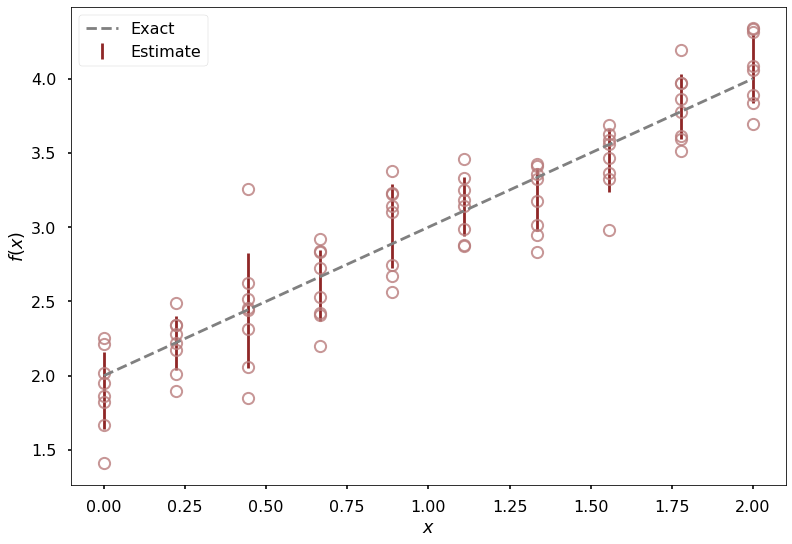

In [55]:
random.seed(12345)

nparams,func  = 2, linear_func
#nparams,func = 3, quadratic_func
_θ0,σ0        = np.array([2.0, 1.0, 0.6]), 0.25  # exact parameter values
θ0            = _θ0[:nparams]

measurement   = make_noisy_func(func, σ0)
npoints,ndraws= 10,8
x_sample      = np.linspace(0, 2.0, num=npoints)
y_sample      = np.array([measurement(θ0,x_sample) for i in range(ndraws)])
y_avg, y_err  = np.average(y_sample, axis=0), np.std(y_sample, axis=0)

fig, ax = plt.subplots()
for yi in y_sample:
    ax.plot(x_sample, yi, marker='o', ls='None', color=color['mid'], mfc='None', mew=2, alpha=0.8)
ax.errorbar(x_sample, y_avg, yerr=y_err, ls='None', label='Estimate', color=color['dark'])
ax.plot(x_sample, func(θ0,x_sample), ls='--', label='Exact', color='Grey')
ax.legend()
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
plt.show()

The symbols represent our "measurement", 8 for each of the 10 $x$ values we are sampling. The average and variance of these measurements would give your experimental estimate (shown here with the error bar plot). 

## The "Least-Squares" route
Let's first attempt a least-squares minimization.

Recall the definition of $\chi^2$
$$\begin{align}
\chi^2 = \sum_k \frac{\left(y_k - f(x_k;\Theta)\right)}{\sigma_k^2}
\end{align}$$

For simple functions, it is trivial to work out the first and second derivatives of this quantity, but jax does all the work for us! As shown above, the best-estimate for $\Theta$ is given by minimizing $\chi^2$, and the realiability estimates are given by (twice) the inverse of the Hessian
$$\begin{align*}
\Theta &= \Theta_0 \pm \sqrt{\text{diag}(\Sigma_{\Theta})}\\
\Sigma_{\Theta}&= 2\left(\nabla\nabla\chi^2\lvert_{\Theta_0}\right)^{-1}
\end{align*}$$

For a the simple linear model we are considering, we can easily work out the analytical solution

$\begin{align}
\partial_m \chi^2 &= \sum_k \frac{2 \left(m x_k + b - y_k\right) x_k}{\sigma_k^2} \qquad
&\partial_b \chi^2 &= \sum_k \frac{2 \left(m x_k + b - y_k\right)}{\sigma_k^2} \\
\nabla\chi^2 &= \begin{pmatrix}\partial_m \chi^2\\\partial_b \chi^2\end{pmatrix} = 
\begin{pmatrix}\sum w_k x_k^2 & \sum w_k x_k\\
\sum w_k x_k & \sum w_k
\end{pmatrix}\begin{pmatrix} m \\ b\end{pmatrix} - \begin{pmatrix}\sum w_k x_k y_k\\
\sum w_k y_k\end{pmatrix} \\
&=\begin{pmatrix}\alpha & \gamma \\\gamma &\beta\end{pmatrix}\begin{pmatrix}m \\ b\end{pmatrix} - \begin{pmatrix}p \\ q\end{pmatrix}
\end{align}$


with $\alpha = \sum w_k x_k^2$, $\beta = \sum_k w_k$, $\gamma=\sum_k w_k x_k$, $w_k = 2/\sigma_k^2$, $p=\sum_k w_k x_k y_k$ and $q=\sum_k w_k y_k$. The optimum solution is then

$\begin{align}
\nabla \chi^2 &= 0 \\
\begin{pmatrix}m\\b\end{pmatrix} &=\begin{pmatrix}\alpha & \gamma\\\gamma &\beta\end{pmatrix}^{-1} \begin{pmatrix}p\\q\end{pmatrix} = \frac{1}{\alpha\beta - \gamma^2} \begin{pmatrix}\beta &-\gamma \\ -\gamma & \alpha\end{pmatrix}
\begin{pmatrix}p\\q\end{pmatrix} = \frac{1}{\alpha\beta-\gamma^2}\begin{pmatrix}
\beta p - \gamma q\\\alpha q - \gamma p
\end{pmatrix}
\end{align}$

Finally, the covariance matrix $\Sigma_{\Theta} = 2 (\nabla\nabla \chi^2)^{-1}$ is just

$\begin{align}
\nabla\nabla \chi^2 &= \begin{pmatrix}\alpha & \gamma\\\gamma & \beta\end{pmatrix} \\
\Sigma_{\Theta} &= 2\frac{1}{\alpha\beta - \gamma^2}\begin{pmatrix}
\beta &-\gamma\\-\gamma & \alpha
\end{pmatrix}
\end{align}$

In [56]:
@jit
def chi2(θ):
    return np.sum((y_avg-func(θ,x_sample))**2/y_err**2)
grad_chi2  = jit(grad(chi2)) # \nabla χ^2
hess_chi2  = hessian(chi2)   # \nabla\nabla χ^2

def exact_sol(xk,yk,dyk):
    wk    = 2/dyk**2
    α,β,γ = np.sum(wk*xk**2), np.sum(wk), np.sum(wk*xk)
    p,q   = np.sum(wk*xk*yk), np.sum(wk*yk)
    idet  = 1.0 / (α*β - γ**2)
    m,b   = idet*(β*p - γ*q), idet*(α*q - γ*p)
    return np.array([b,m]), idet*np.array([[α, -γ], [-γ, β]]) # reorder solution (m,b) -> (b,m)
θgold, iHgold = exact_sol(x_sample, y_avg, y_err)

In [57]:
opt       = minimize(chi2, np.ones_like(θ0), method='BFGS', jac=grad_chi2, options={'maxiter':100, 'disp':1})
opt_ihess = np.linalg.inv(hess_chi2(opt['x'])) # inverse hessian evaluated at the optimum value Θ_0

Optimization terminated successfully.
         Current function value: 1.118355
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7


In [58]:
labels = ['b', 'm']
print(f"|θ - Θ_exact|_inf     = {np.max(np.abs(opt['x']-θgold)):.6e}")
print(f"|H - H_exact|_inf     = {np.max(np.abs(opt_ihess-iHgold)):.6e}")
print(f"|H_min - H_exact|_inf = {np.max(np.abs(opt['hess_inv'] - iHgold)):.6e}")
print("")
for i in range(nparams):
    avg, sigma = opt['x'][i], np.sqrt(opt_ihess[i,i]*2)
    print(f'{avg-2*sigma:.2f} < θ^{i+1} ({labels[i]}) < {avg+2*sigma:.2f} [μ = {avg:.3f}, σ = {sigma:.2f}]')

|θ - Θ_exact|_inf     = 2.442491e-15
|H - H_exact|_inf     = 6.938894e-18
|H_min - H_exact|_inf = 1.040834e-17

1.69 < θ^1 (b) < 2.24 [μ = 1.961, σ = 0.14]
0.79 < θ^2 (m) < 1.24 [μ = 1.018, σ = 0.11]


The exact values used to generate the data were $\Theta^1 = b = 2$ and $\Theta^2 = m = 1$, which is very close to the optimal value obtained here.
Furthermore, we see that the approximate of the Hessian returned by the minimization routine concides with the exact result (given by jax). We use $\pm 2\sigma$ interval as a measure of the error bounds.

## The full Bayesian route

Now let's see how to get the "full" solution, not just a point-estimate. For this we use PYMC3 to generate samples from the posterior.
To compare with our previous analysis, we will assume a uniform prior for both $m$ and $b$.

In [59]:
with pm.Model() as model:
    #priors for unknown model parameters
    m = pm.Uniform('m', lower=-10, upper=10)
    b = pm.Uniform('b', lower=-10, upper=10)
    
    # true function
    y = pm.Deterministic('y', func([b,m], x_sample))
    
    # measured data (accounting for noise)
    yobs = pm.Normal('yobs', mu=y, sd=y_err, observed=y_avg)
    
    # generate samples from the prior (before looking at the data)
    prior_uni = pm.sample_prior_predictive(samples=1000, random_seed = 123456)
    
    # generate samples from the posterior
    trace_uni =  pm.sample(5000, tune = 20000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m]
Sampling 4 chains, 0 divergences: 100%|██████████| 100000/100000 [00:30<00:00, 3227.92draws/s]
The acceptance probability does not match the target. It is 0.6524859617850867, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


First, let us try to get an idea for how good/bad our priors are. We can do this by looking at the prior predictive distribution.
This simply takes parameters values sampled from the prior, and pushes them through the model, generating corresponding samples for $y$.
If we plot $y-b = mx$ we can clearly see that this prior is heavily skewed towards lines with high slopes. Is this what we want? Probably not, but this will depend on our prior information.

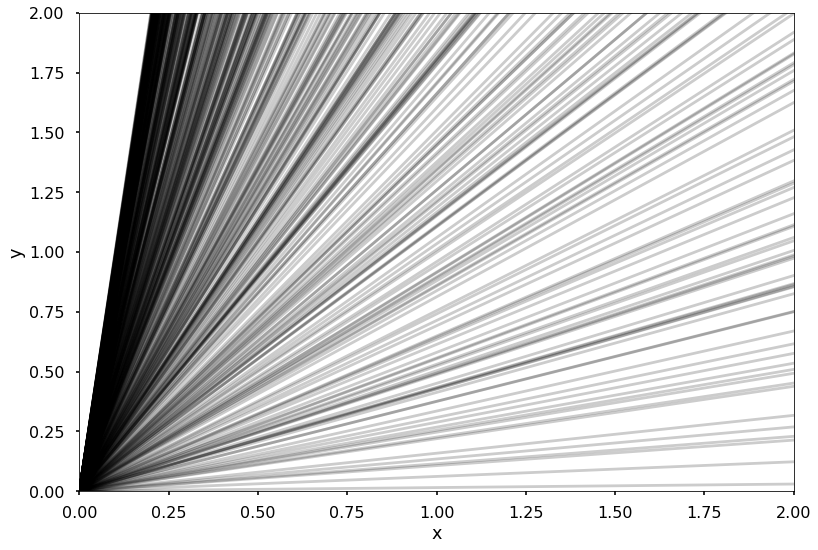

In [60]:
fig, ax = plt.subplots()
for y_i,b_i in zip(prior_uni['y'], prior_uni['b']):
    ax.plot(x_sample, y_i-b_i, alpha=0.2, color='k')
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_ylim(0,2)
ax.set_xlim(0,2)
plt.show()

PYMC3 comes with many useful post-processing functions to visualize our data.
Let's look at a few of them.

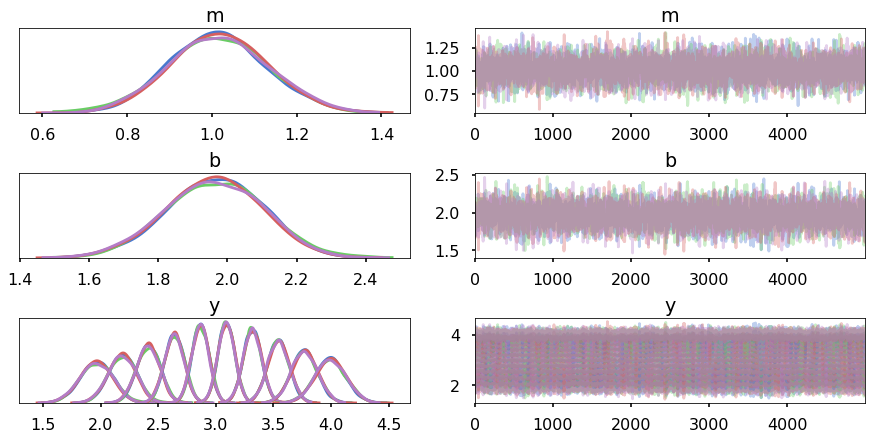

In [61]:
pm.traceplot(trace_uni)
plt.show();

Above, we see the distribution of the model parameters, with different colors corresponding to different chains or independent runs of the MC simulaiton (4 in this case).
At first glance, there doesn't seem to be any obvious divergence and we get nice Gaussian-like distributions for all model parameters (this includes the values of the function at the measured points).

<Figure size 504x504 with 0 Axes>

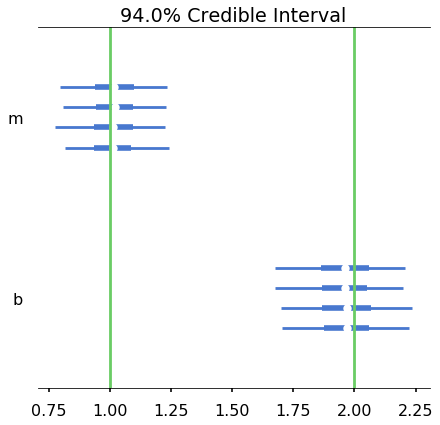

In [62]:
fig = plt.figure(figsize=(7,7))
pm.forestplot(trace_uni, var_names=['m', 'b']);
plt.axvline(1, 0, 1, c='C1')
plt.axvline(2, 0, 1, c='C1')
plt.show();

Here we have the $94\%$ credible intervales, corresonding to the $\mu \pm 2\sigma$ interval in the case of a Gaussian distribution. The vertical lines indicate the real values that were used to generate the data.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2f005d68>,
      dtype=object)

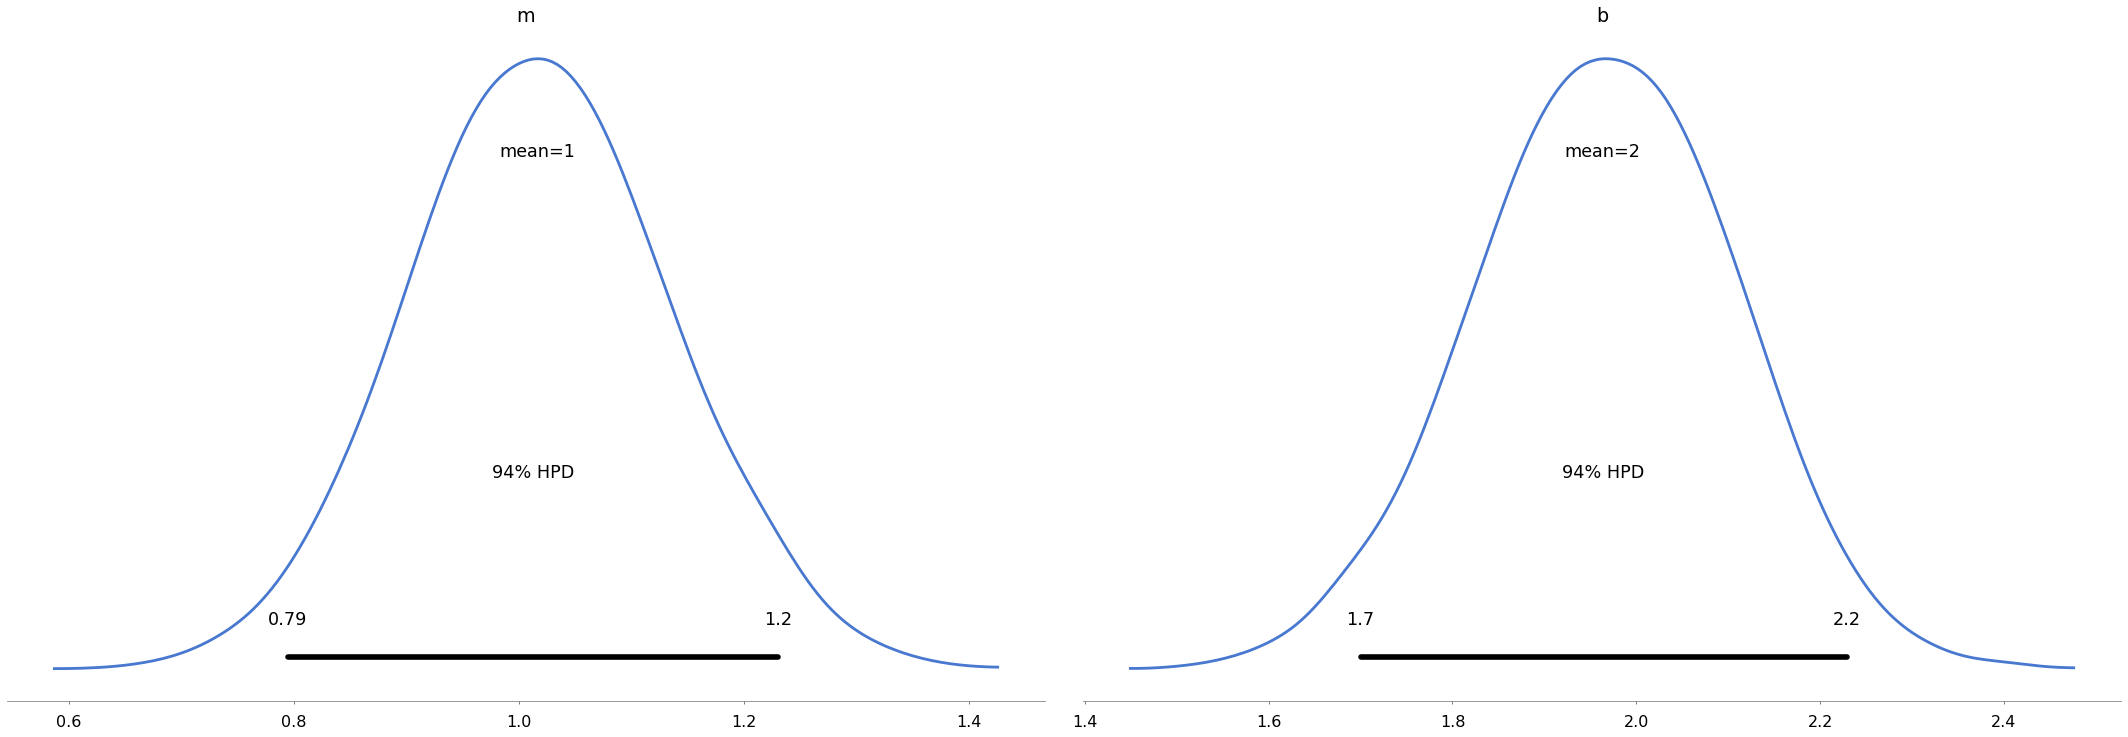

In [65]:
pm.plot_posterior(trace_uni, var_names=['m', 'b'])

Here we have the posterior distribution for our two model parameters. Notice that the $94\%$ HPD (Highest Posterior Density Interval) corresponds exactly to that obtained using the Laplace approximation. This should not be surprising, when we see the posterior.

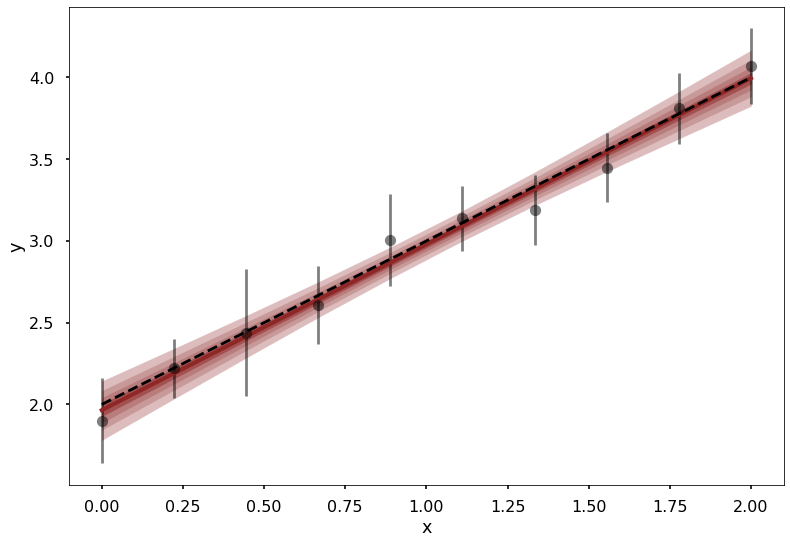

In [71]:
fig, ax = plt.subplots()
plot_quantiles(ax, x_sample, trace_uni['y'])
ax.errorbar(x_sample, y_avg, yerr=y_err, ls='None', marker='o', color=color['superfine'], alpha=0.5)
ax.plot(x_sample, func(θ0,x_sample), ls='--', color=color['superfine'], alpha=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

The shaded red regions show our predictions for $y$, weighted by the posterior distribution over the model parameters.

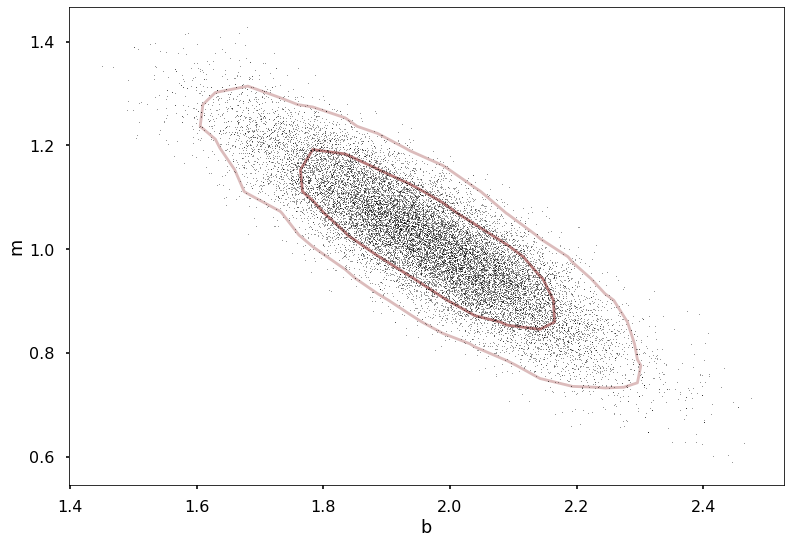

In [107]:
fig, ax = plt.subplots()
plot_MCMC_trace(ax, trace_uni['b'], trace_uni['m'], scatter=True, colors=[color['mid'], color['light']])
ax.set_xlabel('b')
ax.set_ylabel('m')
plt.show()

Here we see the trace generated by the MC simulation, where the distribution of points approximates the the posterior distribution.
Also drawn are the $\pm \sigma$ and $\pm 2\sigma$ contour levels, which should contain $68\%$ and $95\%$ of the points, respectively.

We can redo the analyis using a "better" prior, e.g., assigning a uniform prior on the angles of the lines instead of their slope, but the results will not vary significantly (unless the number of data points is reduced).

# Example : Fitting a straight line with unknown error

Now let's analyze the case where the measurement error is not known.

In [ ]:
@jit
def loss(θ):
    return np.sum((y_sample[0]-func(θ,x_sample))**2)

grad_loss  = jit(grad(loss))
hess_loss  = hessian(loss)   

def exact_sol(xk,yk):
    wk    = 2/dyk**2
    α,β,γ = np.sum(wk*xk**2), np.sum(wk), np.sum(wk*xk)
    p,q   = np.sum(wk*xk*yk), np.sum(wk*yk)
    idet  = 1.0 / (α*β - γ**2)
    m,b   = idet*(β*p - γ*q), idet*(α*q - γ*p)
    return np.array([b,m]), idet*np.array([[α, -γ], [-γ, β]]) # reorder solution (m,b) -> (b,m)
θgold, iHgold = exact_sol(x_sample, y_avg, y_err)

opt       = minimize(loss, np.ones_like(θ0), method='BFGS', jac=grad_loss, options={'maxiter':100, 'disp':1})
opt_ihess = np.linalg.inv(hess_loss(opt['x']))

S0    = loss(opt['x'])
σopt  = np.sqrt(S0/(npoints + 1 - nparams))
dσopt = σopt / np.sqrt(2*(npoints + 1 - nparams))
print(f'{σopt - 2*dσopt:.3f} < σ < {σopt + 2*dσopt:.3f} (μ_σ = {σopt:.3f}, σ_σ={dσopt:.3f})')

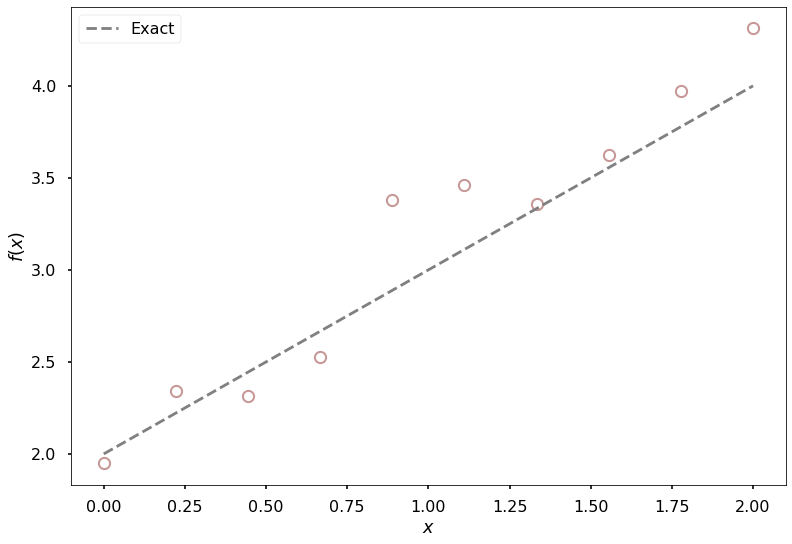

In [112]:
fig, ax = plt.subplots()
ax.plot(x_sample, y_sample[0], marker='o', ls='None', color=color['mid'], mfc='None', mew=2, alpha=0.8)
ax.plot(x_sample, func(θ0,x_sample), ls='--', label='Exact', color='Grey')
ax.legend()
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
plt.show()

In [18]:
with pm.Model() as model_sig:
    #priors for unknown model parameters
    m = pm.Uniform('m', lower=-10, upper=10)
    b = pm.Uniform('b', lower=-10, upper=10)
    logσ = pm.Uniform('logσ', lower=-6, upper=6)
    σ    = pm.Deterministic('σ', tt.exp(logσ))
    y = pm.Deterministic('y', func([b,m], x_sample))
    yobs = pm.Normal('yobs', mu=y, sd=σ, observed=y_sample[0])
    
    prior_sig = pm.sample_prior_predictive(samples=1000, random_seed = 123456)
    trace_sig =  pm.sample(5000, tune = 50000, progressbar=True)
#post_sig = pm.sample_posterior_predictive(trace_uni, model=model_sig, random_seed=4938483)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logσ, b, m]
INFO:pymc3:NUTS: [logσ, b, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 110000/110000 [01:07<00:00, 1636.44draws/s]


<Figure size 864x864 with 0 Axes>

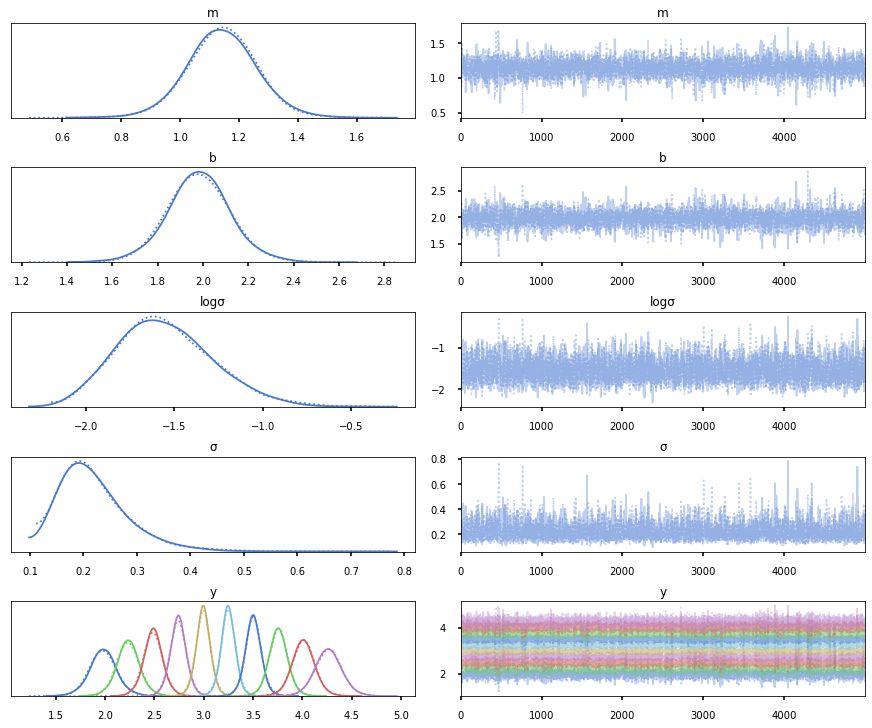

In [19]:
plt.figure(figsize=(12,12))
pm.traceplot(trace_sig)
plt.show();

<Figure size 504x504 with 0 Axes>

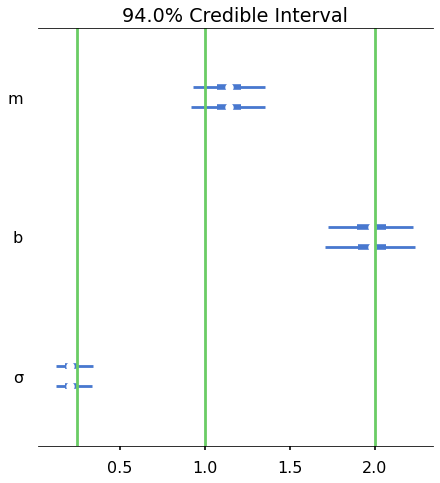

In [20]:
fig = plt.figure(figsize=(7,7))
pm.forestplot(trace_sig, var_names=['m', 'b', 'σ']);
plt.axvline(1, 0, 1, c='C1')
plt.axvline(2, 0, 1, c='C1')
plt.axvline(σ0, 0, 1, c='C1')
plt.show()

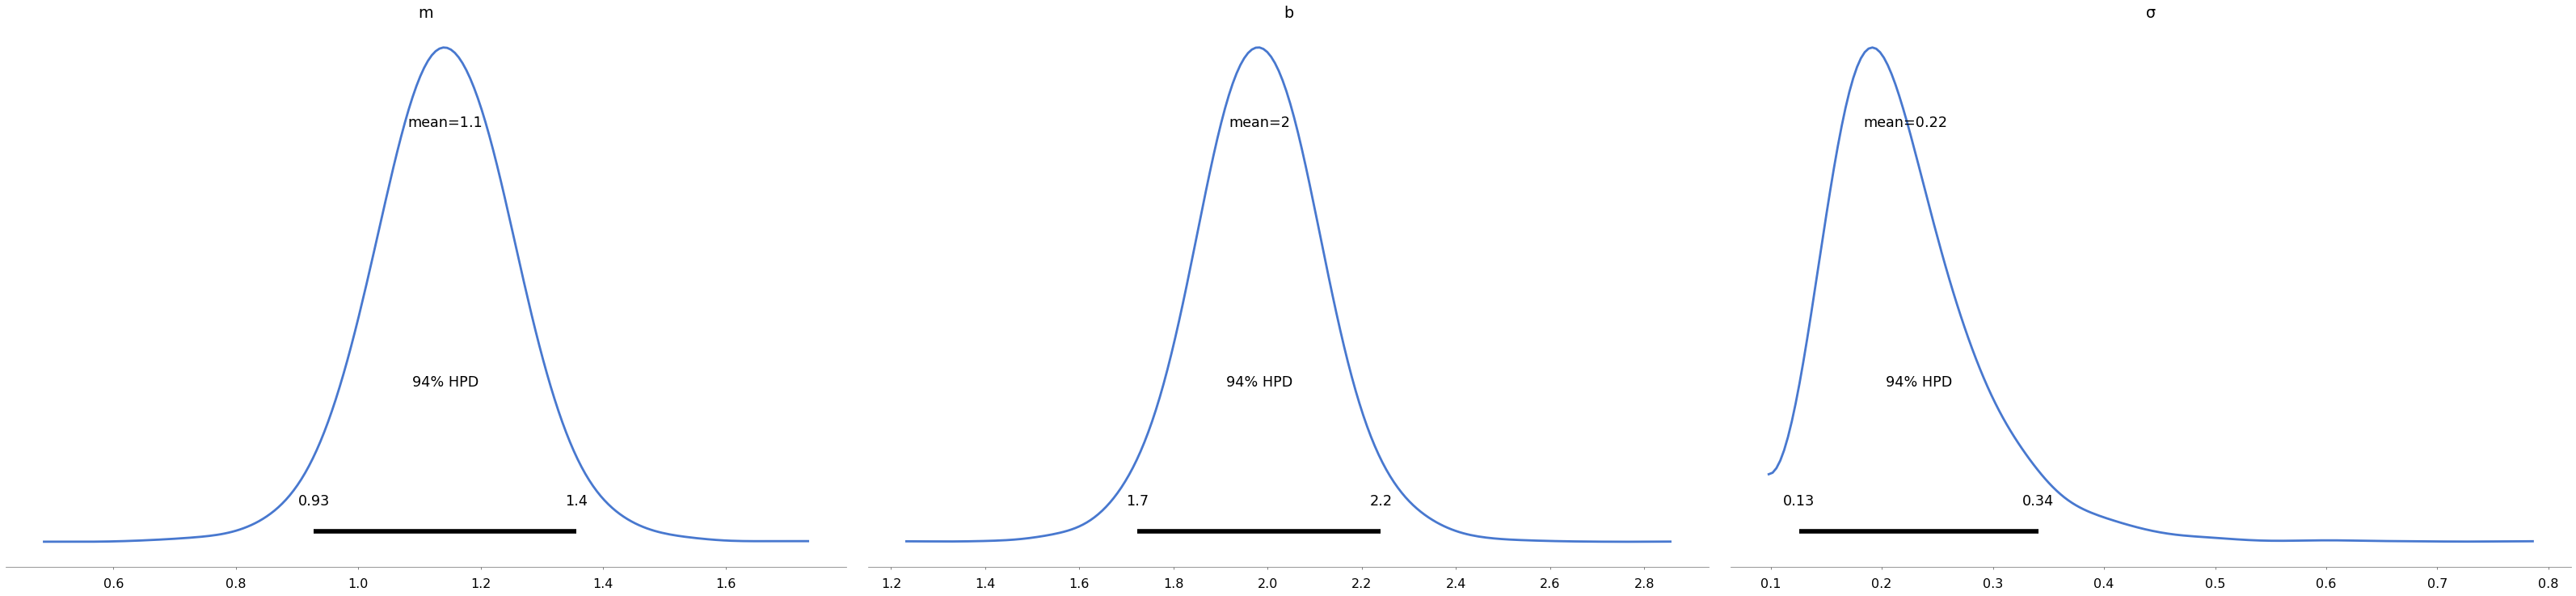

In [21]:
pm.plot_posterior(trace_sig, var_names=['m', 'b', 'σ']);

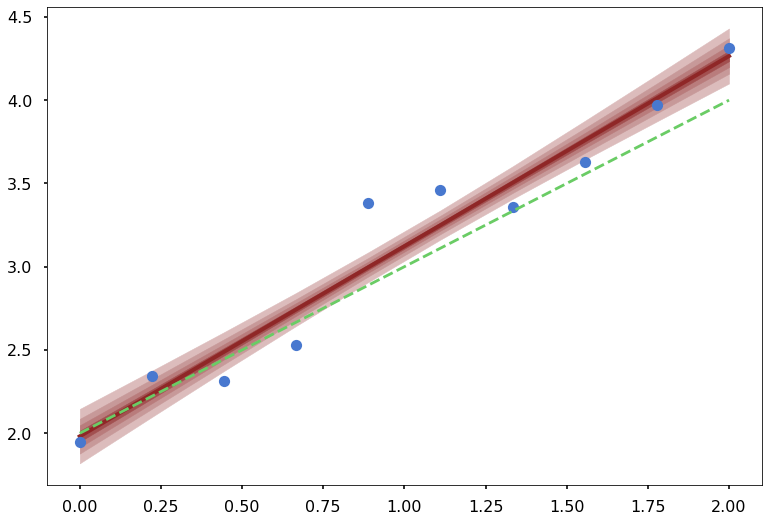

In [22]:
fig, ax = plt.subplots()
plot_quantiles(ax, x_sample, trace_sig['y'])
ax.plot(x_sample, y_sample[0], ls='None', marker='o')
ax.plot(x_sample, func(θ0,x_sample), ls='--')

In [12]:
#collapse
from pip._internal.operations.freeze import freeze
for requirement in freeze(local_only=True):
    print(requirement)

absl-py==0.9.0
appnope==0.1.0
arviz==0.7.0
attrs==19.3.0
backcall==0.1.0
bleach==3.1.4
certifi==2019.11.28
cffi==1.14.0
cftime==1.1.1.2
chardet==3.0.4
cryptography==2.8
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
entrypoints==0.3
fastcache==1.1.0
h5py==2.10.0
idna==2.9
importlib-metadata==1.6.0
ipykernel==5.2.0
ipython==7.13.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jax==0.1.62
jaxlib==0.1.42
jedi==0.16.0
Jinja2==2.11.1
json5==0.9.0
jsonschema==3.2.0
jupyter-client==6.1.2
jupyter-console==6.1.0
jupyter-core==4.6.3
jupyterlab==2.0.1
jupyterlab-server==1.1.0
kiwisolver==1.1.0
Mako==1.1.0
MarkupSafe==1.1.1
matplotlib==3.2.1
mistune==0.8.4
mkl-service==2.3.0
nbconvert==5.6.1
nbformat==5.0.4
netCDF4==1.5.3
notebook==6.0.3
numpy==1.18.1
opt-einsum==0+untagged.53.g6ab433b.dirty
packaging==20.1
pandas==1.0.3
pandocfilters==1.4.2
parso==0.6.2
patsy==0.5.1
pexpect==4.8.0
pickleshare==0.7.5
pip==20.0.2
prometheus-client==0.7.1
prompt-toolkit==3.0.5
protobuf==3.11.4
ptyprocess==0.6.0
pycpa